# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [3]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from itemInfo import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [4]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [5]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [6]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [7]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [8]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [9]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [11]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [12]:
# Remind ourselves the training prompt

print(train[0].prompt)

How much does this cost to the nearest dollar?

BBOUNDER 16 Pack Linkable LED Utility Shop Light, 4 FT, 6500K Cool Daylight, 4400 LM, 48 Inch Integrated Fixture for Garage, 40W Equivalent 250W, Surface + Suspension Mount, White
Super brightness With 4400 lumens brightness at 6500K cool daylight white, these 4ft led shop lights only consume 40W while provide the bright illumination with 250W (6 times more than conventional fluorescent lights). It is an amazing LED Efficiency of 110 lm/w, which can

Price is $195.00


In [13]:
# Remind a test prompt

print(train[0].price)

194.99


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [14]:
class Tester:

    def __init__(self, predictor, title=None, data=test, size=25):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [15]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $87.44 Error: $567.56 SLE: 4.02 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $115.00 Truth: $380.52 Error: $265.52 SLE: 1.42 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $26.00 Truth: $749.00 Error: $723.00 SLE: 11.05 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $760.00 Truth: $40.19 Error: $719.81 SLE: 8.51 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $282.00 Truth: $289.00 Error: $7.00 SLE: 0.00 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $251.00 Truth: $105.54 Error: $145.46 SLE: 0.74 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $229.00 Truth: $659.00 Error: $430.00 SLE: 1.11 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $143.00 Truth: $299.00 Error: $156.00 SLE: 0.54 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $755.00 Truth: $21.88 Error: $733.12 SLE: 12.23 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $105.00 Truth: $251.5

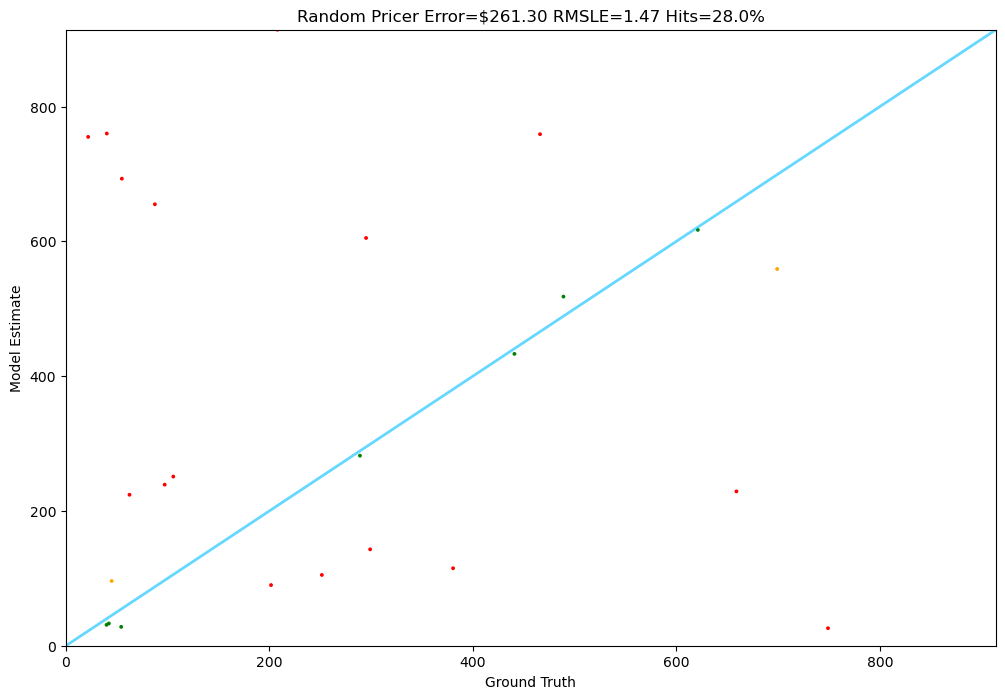

In [16]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [17]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $224.97 Truth: $87.44 Error: $137.53 SLE: 0.88 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $224.97 Truth: $380.52 Error: $155.55 SLE: 0.27 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $224.97 Truth: $749.00 Error: $524.03 SLE: 1.44 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $224.97 Truth: $40.19 Error: $184.78 SLE: 2.90 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $224.97 Truth: $289.00 Error: $64.03 SLE: 0.06 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $224.97 Truth: $105.54 Error: $119.43 SLE: 0.57 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $224.97 Truth: $659.00 Error: $434.03 SLE: 1.15 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $224.97 Truth: $299.00 Error: $74.03 SLE: 0.08 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $224.97 Truth: $21.88 Error: $203.09 SLE: 5.24 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $224.97 Truth: $251.55

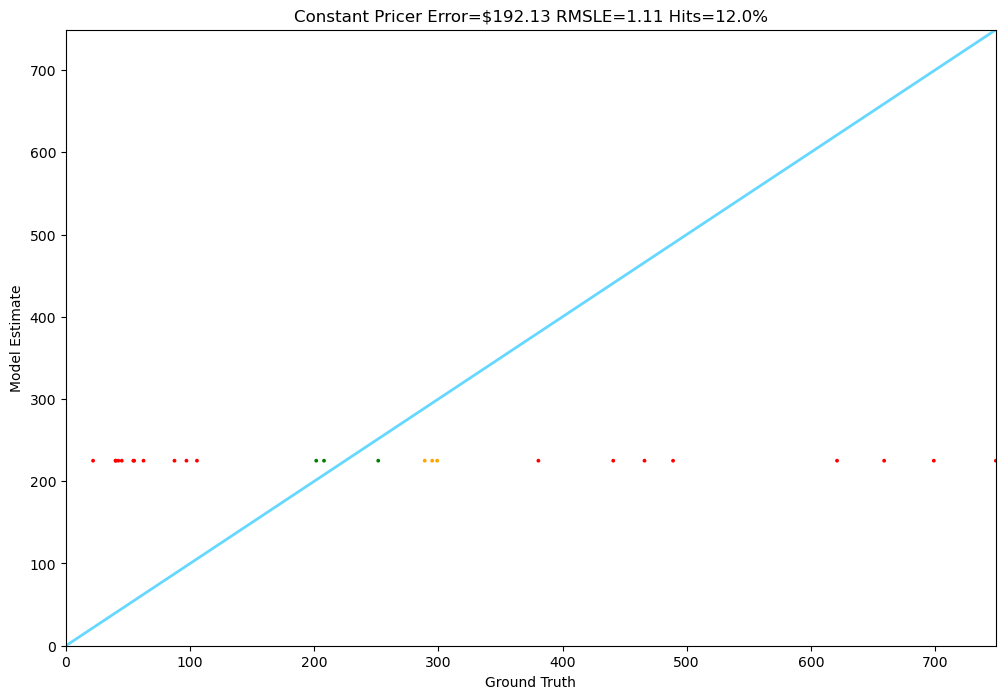

In [18]:
# Run our constant predictor
Tester.test(constant_pricer)


In [19]:
train[0].details

'{"Brand": "BBOUNDER", "Color": "New 6500k White", "Material": "Polycarbonate", "Style": "Modern", "Light fixture form": "Ceiling", "Room Type": "Garage, workbench, warehouse, Utility room, Basement, Workshop, Attic, barn, shed, storage room, equipment room, tool room", "Power Source": "Corded Electric", "Special Feature": "Shatter resistant, Instant on, Non dimmable, No stroboscopic, Energy saving", "Control Method": "App", "Light Source Type": "LED", "Voltage": "120 Volts", "Light Color": "Cool Daylight", "Shape": "Linear", "Included Components": "Mounting Hardware", "Lighting Method": "Downlight", "Number of Items": "16", "Wattage": "40 watts", "Manufacturer": "BBOUNDER", "Part Number": "Led shop light", "Item Weight": "14.67 pounds", "Package Dimensions": "48 x 12.5 x 6 inches; 14.7 Pounds", "Country of Origin": "China", "Item model number": "led shop light", "Special Features": "Shatter resistant, Instant on, Non dimmable, No stroboscopic, Energy saving", "Shade Color": "White", "

In [20]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [21]:
train[0].features.keys()

dict_keys(['Brand', 'Color', 'Material', 'Style', 'Light fixture form', 'Room Type', 'Power Source', 'Special Feature', 'Control Method', 'Light Source Type', 'Voltage', 'Light Color', 'Shape', 'Included Components', 'Lighting Method', 'Number of Items', 'Wattage', 'Manufacturer', 'Part Number', 'Item Weight', 'Package Dimensions', 'Country of Origin', 'Item model number', 'Special Features', 'Shade Color', 'Plug Format', 'Switch Installation Type', 'Batteries Included?', 'Batteries Required?', 'Luminous Flux', 'Color Temperature', 'Average Life', 'Best Sellers Rank', 'Date First Available'])

In [22]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 358982),
 ('Manufacturer', 347819),
 ('Item Weight', 346979),
 ('Brand', 337343),
 ('Best Sellers Rank', 325666),
 ('Item model number', 275501),
 ('Product Dimensions', 259068),
 ('Color', 176427),
 ('Is Discontinued By Manufacturer', 171280),
 ('Manufacturer Part Number', 147196),
 ('Material', 131928),
 ('Country of Origin', 116391),
 ('Style', 74515),
 ('Part Number', 72951),
 ('Package Dimensions', 72358),
 ('Batteries Required?', 71410),
 ('Special Feature', 70959),
 ('Item Dimensions LxWxH', 69551),
 ('Model', 64649),
 ('Included Components', 64230),
 ('Item Package Quantity', 56998),
 ('OEM Part Number', 55806),
 ('Size', 55512),
 ('Batteries Included?', 55312),
 ('Special Features', 50466),
 ('Exterior', 50276),
 ('Vehicle Service Type', 48691),
 ('Power Source', 47886),
 ('Voltage', 44434),
 ('Finish Type', 43889),
 ('Mounting Type', 36368),
 ('Model Name', 36286),
 ('Shape', 33275),
 ('Number of Items', 30569),
 ('Connectivity Technology', 30485),
 

In [23]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [24]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

4.75 Tons


In [25]:
average_weight = sum(weights)/len(weights)
average_weight

13.661211051217416

In [26]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [27]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [28]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

391943.60758729384

In [29]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [30]:
def get_text_length(item):
    return len(item.test_prompt())

In [31]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5439),
 ('Power Stop', 3460),
 ('Dell', 3235),
 ('Detroit Axle', 2483),
 ('Lenovo', 2365),
 ('Dorman', 1986),
 ('SAMSUNG', 1756),
 ('BUYAUTOPARTS!', 1660),
 ('WeatherTech', 1521),
 ('ACDelco', 1512),
 ('Evan Fischer', 1385),
 ('ASUS', 1372),
 ('Sony', 1270),
 ('Canon', 1231),
 ('Kohler', 1100),
 ('Callahan BRAKE PARTS', 1064),
 ('R1 Concepts', 1051),
 ('CURT', 1025),
 ('Coverking', 921),
 ('Rareelectrical', 856),
 ('Moen', 820),
 ('Kingston Brass', 820),
 ('Garage-Pro', 816),
 ('GM', 801),
 ('Auto Dynasty', 794),
 ('Generic', 790),
 ('Apple', 788),
 ('Spectra Premium', 777),
 ('K&N', 772),
 ('DELTA FAUCET', 749),
 ('EBC Brakes', 725),
 ('Cardone', 716),
 ('APS', 703),
 ('Walker', 681),
 ('AM Autoparts', 645),
 ('Intel', 642),
 ('Covercraft', 638),
 ('TRQ', 629),
 ('Westin', 627),
 ('Panasonic', 612)]

In [32]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [33]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [35]:
# Look at features in a training item
get_features(train[0])

{'weight': 14.67,
 'rank': 304549.0,
 'text_length': 513,
 'is_top_electronics_brand': 0}

In [36]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

4.75 Tons


In [37]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2574352263752783
rank: 5.1422394336394596e-05
text_length: -0.012170833797318136
is_top_electronics_brand: 189.99933593950448
Intercept: 200.08291262236528
Mean Squared Error: 26760.19475787081
R-squared Score: 0.09367496686277799


In [38]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $193.26 Truth: $87.44 Error: $105.82 SLE: 0.62 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $276.60 Truth: $380.52 Error: $103.92 SLE: 0.10 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $193.75 Truth: $749.00 Error: $555.25 SLE: 1.82 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $197.90 Truth: $40.19 Error: $157.71 SLE: 2.48 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $194.31 Truth: $289.00 Error: $94.69 SLE: 0.16 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $197.30 Truth: $105.54 Error: $91.76 SLE: 0.39 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $389.77 Truth: $659.00 Error: $269.23 SLE: 0.27 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $198.13 Truth: $299.00 Error: $100.87 SLE: 0.17 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $194.05 Truth: $21.88 Error: $172.17 SLE: 4.59 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $218.84 Truth: $251.55

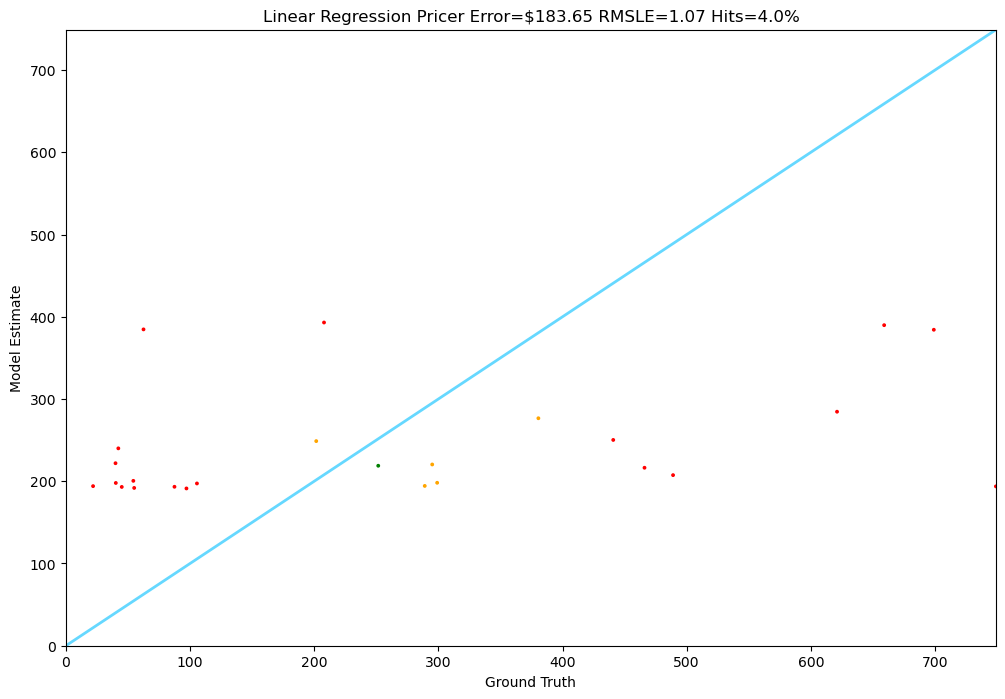

In [39]:
# test it

Tester.test(linear_regression_pricer)

In [40]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [41]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [42]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $236.63 Truth: $87.44 Error: $149.19 SLE: 0.98 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $350.70 Truth: $380.52 Error: $29.82 SLE: 0.01 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $307.98 Truth: $749.00 Error: $441.02 SLE: 0.79 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $142.97 Truth: $40.19 Error: $102.78 SLE: 1.57 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $132.81 Truth: $289.00 Error: $156.19 SLE: 0.60 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $230.44 Truth: $105.54 Error: $124.90 SLE: 0.60 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $520.36 Truth: $659.00 Error: $138.64 SLE: 0.06 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $240.38 Truth: $299.00 Error: $58.62 SLE: 0.05 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $127.72 Truth: $21.88 Error: $105.84 SLE: 2.98 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $237.81 Truth: $251.55

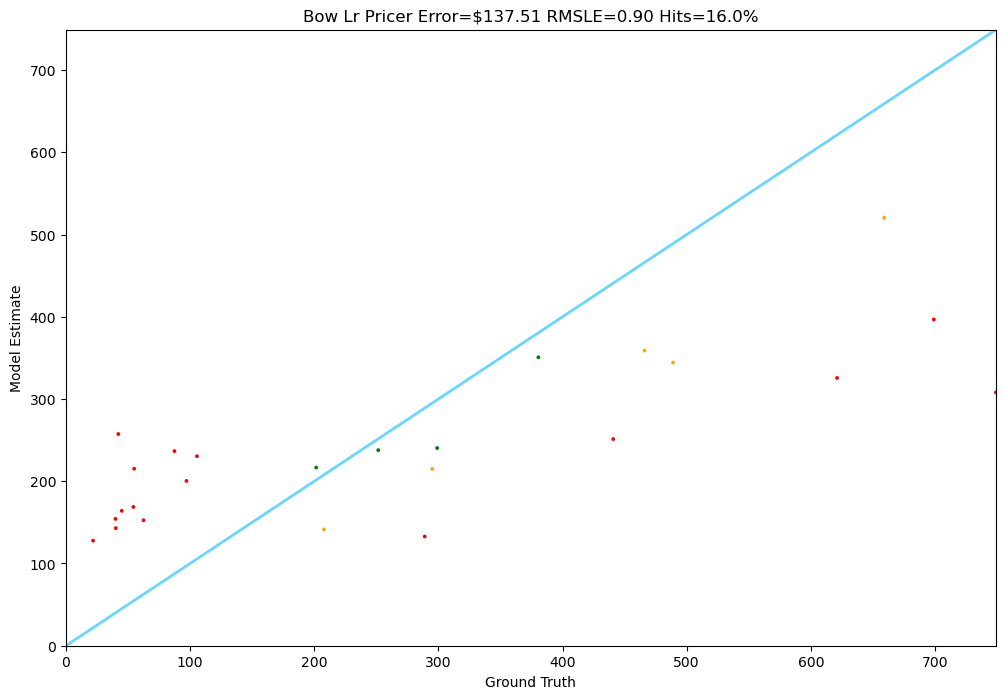

In [43]:
# test it

Tester.test(bow_lr_pricer)

In [44]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [45]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [46]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [47]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $248.62 Truth: $87.44 Error: $161.18 SLE: 1.08 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $352.92 Truth: $380.52 Error: $27.60 SLE: 0.01 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $310.48 Truth: $749.00 Error: $438.52 SLE: 0.77 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $213.51 Truth: $40.19 Error: $173.32 SLE: 2.72 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $236.65 Truth: $289.00 Error: $52.35 SLE: 0.04 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $319.26 Truth: $105.54 Error: $213.72 SLE: 1.21 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $530.17 Truth: $659.00 Error: $128.83 SLE: 0.05 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $263.01 Truth: $299.00 Error: $35.99 SLE: 0.02 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $141.53 Truth: $21.88 Error: $119.65 SLE: 3.35 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $210.81 Truth: $251.55 

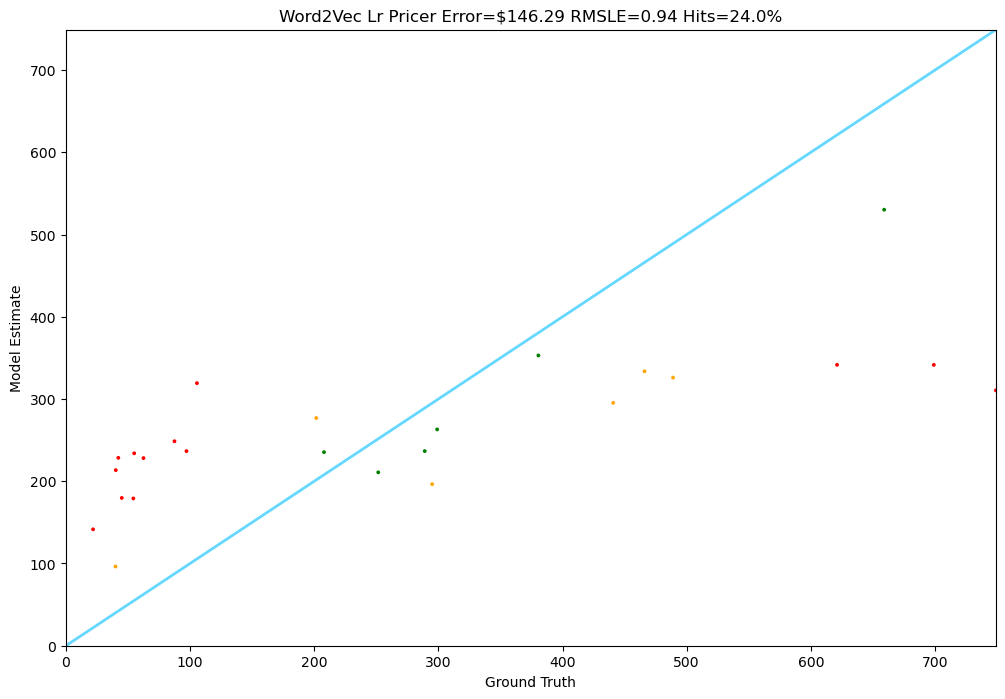

In [48]:
Tester.test(word2vec_lr_pricer)

In [49]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [50]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $192.95 Truth: $87.44 Error: $105.51 SLE: 0.62 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $363.50 Truth: $380.52 Error: $17.02 SLE: 0.00 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $242.84 Truth: $749.00 Error: $506.16 SLE: 1.26 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $117.91 Truth: $40.19 Error: $77.72 SLE: 1.12 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $168.83 Truth: $289.00 Error: $120.17 SLE: 0.29 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $248.88 Truth: $105.54 Error: $143.34 SLE: 0.73 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $467.90 Truth: $659.00 Error: $191.10 SLE: 0.12 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $206.60 Truth: $299.00 Error: $92.40 SLE: 0.14 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $101.42 Truth: $21.88 Error: $79.54 SLE: 2.25 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $194.36 Truth: $251.55 E

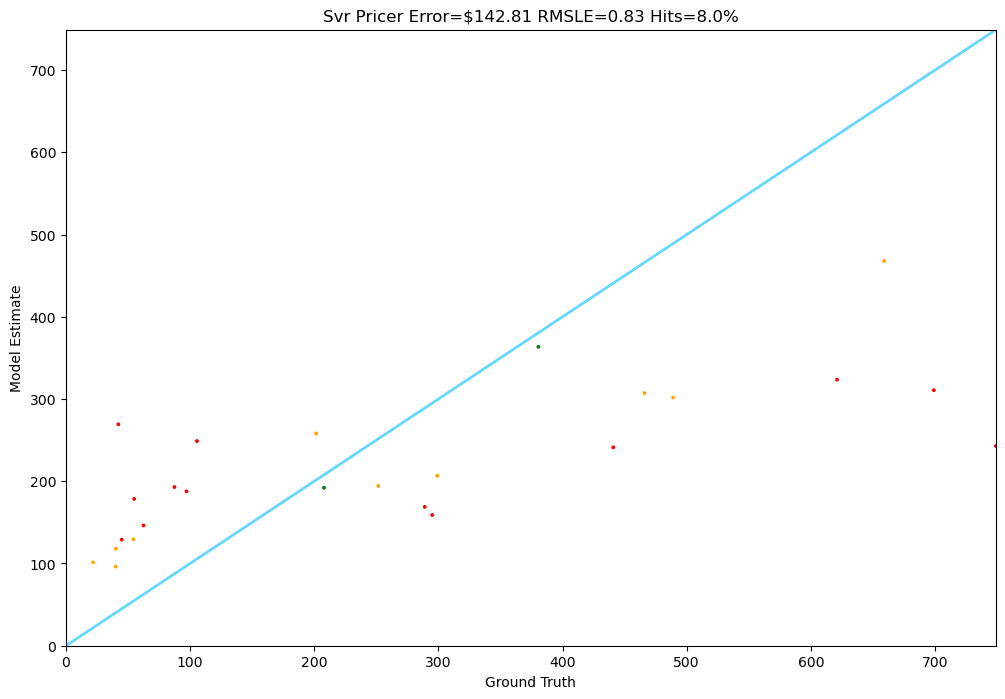

In [51]:
Tester.test(svr_pricer)

In [52]:
# And the powerful Random Forest regression
# this will take around 60 minutes to run
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
#Uncomment next line if you like to run random forest model for an hour 
#rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [53]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $243.43 Truth: $87.44 Error: $155.99 SLE: 1.03 Item: MFJ-1752 Base Antenna, 1.25m, 4ft w/Grou...
2: Guess: $380.98 Truth: $380.52 Error: $0.46 SLE: 0.00 Item: R1 Concepts Front Rear Brakes and Rotors...
3: Guess: $340.96 Truth: $749.00 Error: $408.04 SLE: 0.62 Item: Sigma 18-35mm F1.8 Art DC HSM Lens for P...
4: Guess: $165.03 Truth: $40.19 Error: $124.84 SLE: 1.94 Item: Premier 133504 Premier Cartridge with St...
5: Guess: $299.59 Truth: $289.00 Error: $10.59 SLE: 0.00 Item: Sense Energy Monitor with Solar – Track ...
6: Guess: $156.34 Truth: $105.54 Error: $50.80 SLE: 0.15 Item: HGST HUS724020ALE640 2TB 3.5-inch SATA 7...
7: Guess: $654.64 Truth: $659.00 Error: $4.36 SLE: 0.00 Item: HP 2022 Newest 17z Laptop, 17.3'' HD+ To...
8: Guess: $265.50 Truth: $299.00 Error: $33.50 SLE: 0.01 Item: DEWALT DCS369P1 Atomic 20V Max* Cordless...
9: Guess: $135.60 Truth: $21.88 Error: $113.72 SLE: 3.19 Item: LIT-PaTH Outdoor Post Light Mounting Bas...
10: Guess: $255.18 Truth: $251.55 Erro

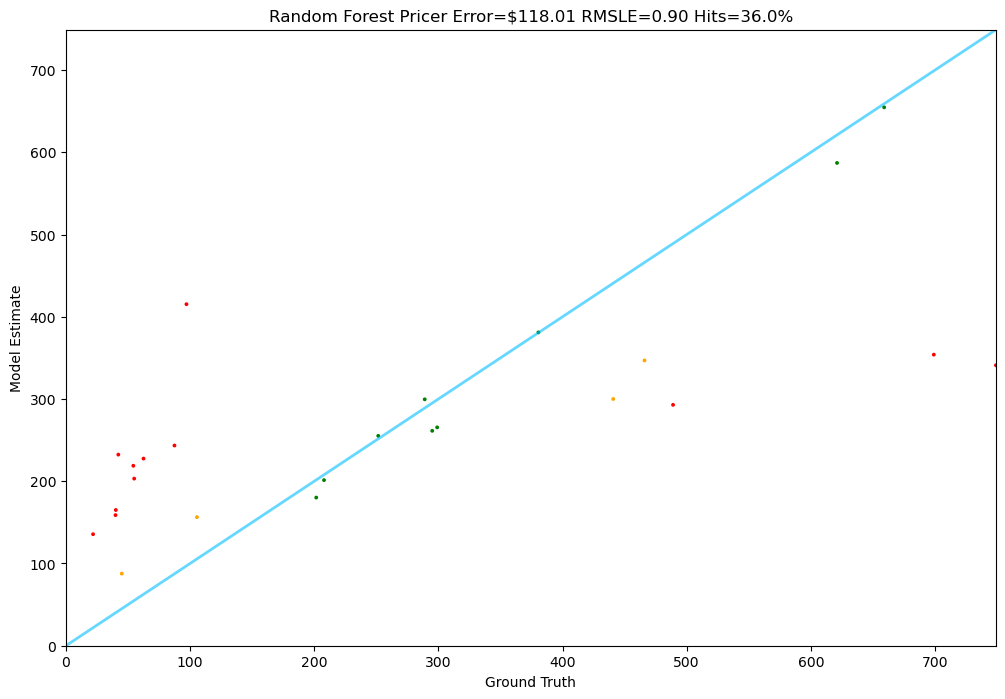

In [54]:
 Tester.test(random_forest_pricer)

In [55]:
import pickle
with open('random_forest_pricer.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


In [62]:
from huggingface_hub import HfApi

In [60]:
HF_USER = "aiml34"
REPO_ID = f"{HF_USER}/pricer-model"  # you can name this repository as you wish
hf_token = os.getenv("HF_TOKEN")  # make sure your token is set in your environment

In [65]:
api = HfApi(token=hf_token)

api.upload_file(
    path_or_fileobj="random_forest_pricer.pkl",     # path to your local pickle file
    path_in_repo="random_forest_pricer.pkl",          # path where it will be stored in the repo
    repo_id=REPO_ID,                      # your repository id
    repo_type="model",                    # specify the repo type (e.g., "model")
    revision="main"                       # branch or revision name
)

random_forest_pricer.pkl:   0%|          | 0.00/3.40G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/aiml34/pricer-model/commit/9ddccd7e4b6f62a9eadd2fb5464c0b1e99a32e90', commit_message='Upload random_forest_pricer.pkl with huggingface_hub', commit_description='', oid='9ddccd7e4b6f62a9eadd2fb5464c0b1e99a32e90', pr_url=None, repo_url=RepoUrl('https://huggingface.co/aiml34/pricer-model', endpoint='https://huggingface.co', repo_type='model', repo_id='aiml34/pricer-model'), pr_revision=None, pr_num=None)